# Load and setup the data and variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score

In [2]:
mouse_genes = pd.read_csv("../../data/prepared/mouse_scaled.tsv.gz", sep="\t", header=0, index_col=[0,1])
human_genes = pd.read_csv("../../data/prepared/human_scaled.tsv.gz", sep="\t", header=0, index_col=[0,1])
mouse_genes.head().iloc[:,:5]

Xkr4     Gm1992    Gm37381        Rp1     Mrpl15
celltype donor_id                                                        
E_1      F003      150.431298  96.168484   5.888929  23.691612  77.763569
         F004      146.923587  88.845963  13.489568  21.113059  83.094336
         F005      155.846667  99.615089  10.187479  25.548710  78.363895
         F006      152.220075  93.619603   7.656298  22.170951  80.374269
         F007      156.802103  96.535744   3.521052  29.365177  78.778955

In [3]:
mouse_genes.shape

(280, 19074)

In [4]:
human_genes.shape

(111, 12383)

We have to capitalize all of the gene names.

In [5]:
mouse_genes.columns = [gene.upper() for gene in mouse_genes.columns]
human_genes.columns = [gene.upper() for gene in human_genes.columns]
mouse_genes.columns

Index(['XKR4', 'GM1992', 'GM37381', 'RP1', 'MRPL15', 'LYPLA1', 'GM37988',
       'TCEA1', 'RGS20', 'GM16041',
       ...
       'MT-ND5', 'MT-ND6', 'MT-CYTB', 'VAMP7', 'SPRY3', 'TMLHE', 'AC132444.5',
       'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1'],
      dtype='object', length=19074)

We're only interested in genes that are shared between the two species.

In [6]:
genes = list(set(mouse_genes.columns).intersection(human_genes.columns))
len(genes)

11139

In [7]:
mouse_genes = mouse_genes.loc[:,genes].T
human_genes = human_genes.loc[:,genes].T
mouse_genes.head().iloc[:,:5]

celltype         E_1                                                
donor_id        F003        F004        F005        F006        F007
F13A1      14.915971   10.560505   12.900630   11.599567    7.936918
SPATS2     92.424719   91.235833   94.383345   94.006557   95.387899
KIF3B      92.375848   89.406392   93.224645   92.143975   88.331003
DCBLD1     85.713962   88.987433   87.019302   87.388880   88.114241
HECW2     138.231901  137.812936  139.957263  141.203944  140.525995

# Retrieve gene correlation network

In [8]:
import igraph as ig
import leidenalg as la
# from umap import UMAP

In [9]:
from scipy.stats import rankdata

In [10]:
from numpy import corrcoef

In [11]:
corr_mouse = corrcoef(mouse_genes.values, mouse_genes.values)[:human_genes.shape[0], :human_genes.shape[0]]

In [12]:
corr_human = corrcoef(human_genes.values, human_genes.values)[:human_genes.shape[0], :human_genes.shape[0]]

In [13]:
corr_human.shape

(11139, 11139)

In [16]:
m, n = human_genes.shape

In [14]:
# n=158
# fig, ax = plt.subplots(figsize=(6,6))
# ax.hist(corr_human.flat, bins=100, density=True)
# x = np.linspace(norm.ppf(0.01, scale=(1/np.sqrt(n-2))),
#                 norm.ppf(0.99, scale=(1/np.sqrt(n-2))), 100)
# ax.plot(x, norm.pdf(x),
#        'r-', lw=5, alpha=0.6, label='norm pdf')

In [15]:
?norm.ppf

Object `norm.ppf` not found.


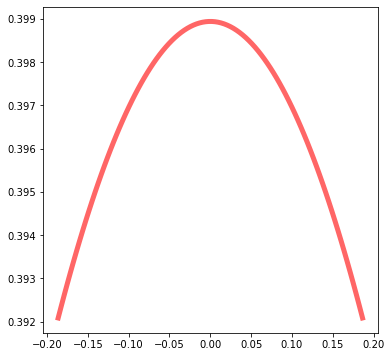

In [17]:
from scipy.stats import norm
fig, ax = plt.subplots(figsize=(6,6))
x = np.linspace(norm.ppf(0.01, scale=(1/np.sqrt(n-2))),
                norm.ppf(0.99, scale=(1/np.sqrt(n-2))), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

In [18]:
# import seaborn as sns
# sns.heatmap(corr_human)

In [15]:
def get_comparative_inds(corr_a, corr_b, n_idx = 30):
    """
    Identifies the top n indecies in a for each row in a, 
    as well as the ranks of the corresponding indexs for the same row in be b
    
    
    inputs:
        corr_a : a matrix of correlation coefficients
        corr_b : a different matrix of correlation coefficients
        n_idx : the number of indicies to check
    """
    
    top_n_a = np.argsort(corr_a)[:, -(n_idx+1):-1]
    idx_ranks_b = rankdata(corr_b, axis=0)
    idx_ranks_b = idx_ranks_b
#     ranks_in_b = [idx_ranks_b[i, top_n_a[i]][::-1] for i in range(len(corr_a))] 
    return idx_ranks_b, top_n_a

In [16]:
# top N co-expressed genes species a
# rank coexpression for species b
# get auroc of ranks, where true positives are top N in a

In [17]:
m_ranks, top_in_h = get_comparative_inds(corr_human, corr_mouse)

In [18]:
h_ranks, top_in_m = get_comparative_inds(corr_mouse, corr_human)

In [19]:
aucs_htom=[]
for i in range(m_ranks.shape[0]):
    labels = np.zeros(top_in_h.shape[0])
    labels[top_in_h[i]] = 1
    aucs_htom.append(roc_auc_score(y_true=labels, y_score=m_ranks[i]))

(array([  1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   2.,
          2.,   2.,   3.,   5.,   5.,  13.,   3.,   9.,  11.,  16.,  21.,
         15.,  19.,  25.,  21.,  33.,  34.,  32.,  37.,  50.,  51.,  49.,
         47.,  72.,  82.,  93., 103., 107., 105.,  90., 113., 122., 136.,
        159., 147., 158., 177., 169., 195., 173., 189., 222., 216., 217.,
        211., 231., 221., 252., 240., 234., 225., 230., 243., 224., 223.,
        217., 226., 240., 226., 210., 244., 219., 228., 208., 196., 215.,
        214., 183., 171., 157., 194., 172., 185., 159., 172., 126., 125.,
        136., 121., 123., 100.,  79.,  63.,  47.,  39.,  24.,  22.,   5.,
          5.]),
 array([0.0705194 , 0.07961392, 0.08870843, 0.09780295, 0.10689747,
        0.11599199, 0.12508651, 0.13418102, 0.14327554, 0.15237006,
        0.16146458, 0.1705591 , 0.17965361, 0.18874813, 0.19784265,
        0.20693717, 0.21603169, 0.2251262 , 0.23422072, 0.24331524,
        0.25240976, 0.26150428, 0.27059879, 0.

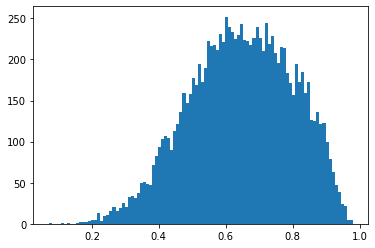

In [20]:
plt.hist(aucs_htom, bins=100)

In [21]:
aucs_mtoh=[]
for i in range(h_ranks.shape[0]):
    labels = np.zeros(top_in_m.shape[0])
    labels[top_in_m[i]] = 1
    aucs_mtoh.append(roc_auc_score(y_true=labels, y_score=h_ranks[i]))

(array([  1.,   0.,   0.,   0.,   2.,   3.,   0.,   3.,   2.,   3.,   4.,
          9.,   1.,  13.,  16.,   9.,  16.,  12.,  15.,   9.,  21.,  26.,
         21.,  27.,  34.,  27.,  38.,  37.,  49.,  57.,  61.,  69.,  73.,
         79.,  97.,  86.,  85.,  83., 108., 103., 138., 139., 144., 136.,
        155., 188., 161., 203., 176., 197., 204., 180., 181., 221., 199.,
        226., 223., 194., 225., 224., 216., 217., 239., 204., 216., 238.,
        211., 197., 224., 219., 234., 212., 204., 195., 180., 211., 208.,
        206., 218., 188., 169., 150., 147., 164., 147., 146., 110., 120.,
        110., 107.,  98., 108.,  58.,  81.,  50.,  47.,  31.,  26.,  12.,
          8.]),
 array([0.11344405, 0.12201376, 0.13058346, 0.13915316, 0.14772287,
        0.15629257, 0.16486227, 0.17343198, 0.18200168, 0.19057138,
        0.19914109, 0.20771079, 0.21628049, 0.2248502 , 0.2334199 ,
        0.2419896 , 0.25055931, 0.25912901, 0.26769871, 0.27626842,
        0.28483812, 0.29340782, 0.30197753, 0.

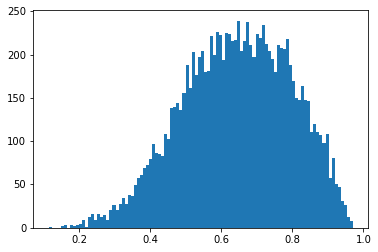

In [22]:
plt.hist(aucs_mtoh, bins=100)

In [23]:
gene_aucs = pd.DataFrame(index=mouse_genes.index, columns=['mouse_auc', 'human_auc'], data=np.array([aucs_mtoh, aucs_htom]).T)

In [24]:
gene_aucs

,mouse_auc,human_auc
F13A1,0.547525,0.528712
SPATS2,0.581808,0.640356
KIF3B,0.789509,0.788793
DCBLD1,0.628691,0.686419
HECW2,0.674420,0.671078
...,...,...
PRDX6,0.580241,0.570452
GARNL3,0.447609,0.506826
PGD,0.532124,0.513908
TM9SF2,0.753404,0.625442


In [25]:
gene_aucs

,mouse_auc,human_auc
HMOX2,0.576908,0.549126
STX2,0.787897,0.798453
RYR2,0.803576,0.760373
DIAPH3,0.448813,0.627500
SLC17A6,0.663413,0.766580
...,...,...
ABCB11,0.490558,0.665805
GLB1L2,0.542298,0.599847
RHBDL2,0.841166,0.672655
TCTN3,0.646876,0.680856


In [26]:
gene_aucs.to_csv("../../data/prepared/aucs.tsv.gz", sep="\t")

In [27]:
spearmanr(gene_aucs.mouse_auc.values, gene_aucs.human_auc.values)

SpearmanrResult(correlation=0.8376050039035458, pvalue=0.0)